In [45]:
#Cargamos librerías

import numpy as np
import pandas as pd
import seaborn as sns             # statistical data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import statsmodels.api as sm
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')




In [46]:
#Cargamos datos diarios para el primer ser de keywords
# Ruta al archivo CSV
ruta_csv_d = r"C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\Spain\Aragón\Clean\Google_Trends.Zaragoza_1_Daily.csv"

# Cargar el CSV en un DataFrame para las frecuencias dirias 
df = pd.read_csv(ruta_csv_d, delimiter = ',', encoding='utf-8')

# Convertir la columna "Fecha" a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

# Filtrar los días que no son fin de semana (lunes a viernes)
df = df[df['Fecha'].dt.dayofweek < 5]

festivos = holidays.Spain(years=df['Fecha'].dt.year.unique())
festivos_espana = [fecha.strftime('%Y-%m-%d') for fecha in festivos.keys()]

# Filtrar el DataFrame para mantener solo los días que son festivos
df_festivos = df[df['Fecha'].dt.strftime('%Y-%m-%d').isin(festivos_espana)]

print(df.head())

   ansiedad  depresión  psicólogo  psicoterapia  desánimo      Fecha
0         0          0          0             0         0 2018-06-01
3       100          0          0             0         0 2018-06-04
4         0          0          0             0         0 2018-06-05
5       100          0          0             0         0 2018-06-06
6         0          0          0             0         0 2018-06-07


In [47]:
#Comenzamos análisis exxploratorio 
print(df[df.isnull()].count())
print(df[df.Fecha.duplicated()]['Fecha'].count())

print('Fecha inicio del histórico: ', df.Fecha.min())
print('Fecha fin del histórico: ', df.Fecha.max())
print('Número total de días: ', df.Fecha.nunique())

ansiedad        0
depresión       0
psicólogo       0
psicoterapia    0
desánimo        0
Fecha           0
dtype: int64
0
Fecha inicio del histórico:  2018-06-01 00:00:00
Fecha fin del histórico:  2023-09-19 00:00:00
Número total de días:  1371


In [48]:
# Aplicar promedio semanal para la consistencia de las series 

date_range = pd.period_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='W-SUN')
date_range = date_range.map(str)
date_range = date_range.str.split('/').str[0]
date_range = pd.Series(date_range)


# Seleccionamos las columnas que deseas promediar
columns_to_average = ['ansiedad', 'depresión', 'psicólogo', 'psicoterapia', 'desánimo']
    
data_grouped = df.groupby([[i // 7 for i in range(len(df))]], axis=0)[columns_to_average].mean()
data_grouped = data_grouped.assign(Weeks=date_range)
print(data_grouped.set_index(['Weeks']).tail(5))    


             ansiedad  depresión  psicólogo  psicoterapia  desánimo
Weeks                                                              
2022-01-24  14.285714   0.000000   0.000000      0.000000       0.0
2022-01-31  35.857143   6.000000   0.000000     29.571429       0.0
2022-02-07  36.428571   4.142857   2.285714      0.000000       0.0
2022-02-14  36.142857   0.000000   4.714286     16.285714       0.0
2022-02-21  31.000000   2.333333   0.000000      0.000000       0.0


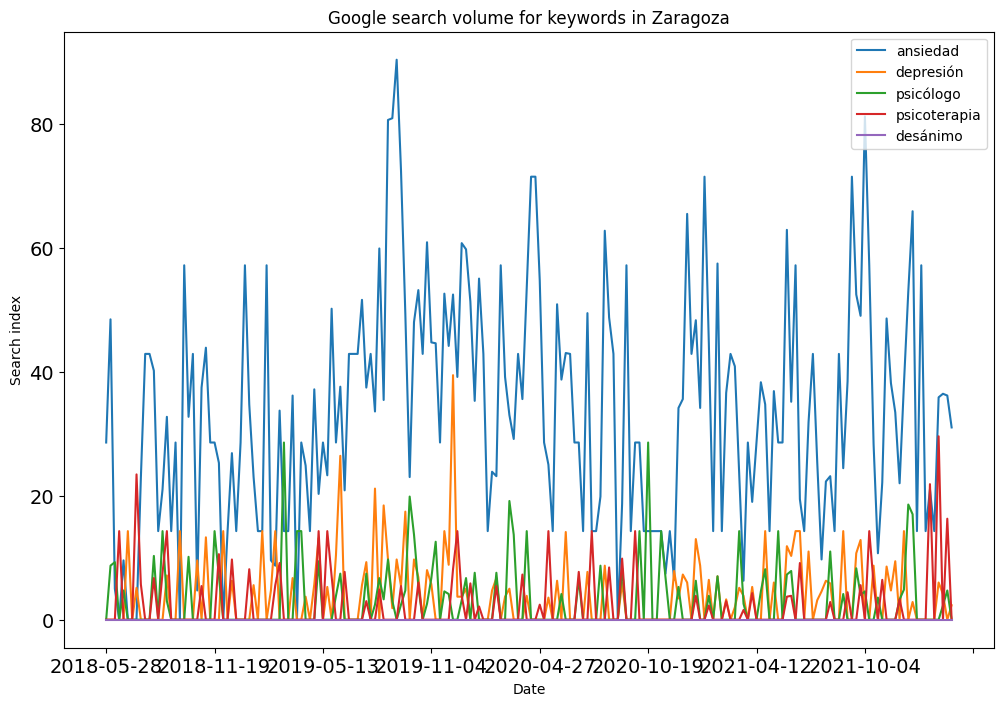

In [49]:
#Graficamos serie
import matplotlib.pyplot as plt

# Supongamos que data_grouped tiene las columnas: fecha, ansiedad, depresión, psicólogo, psicoterapia, desánimo
data_grouped[['Weeks', 'ansiedad', 'depresión', 'psicólogo', 'psicoterapia', 'desánimo']].plot(x='Weeks', figsize=(12, 8), title='Google search volume for keywords in Zaragoza', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Search index')
plt.legend(loc='upper right')  # Agrega una leyenda
plt.show()



<Figure size 640x480 with 0 Axes>

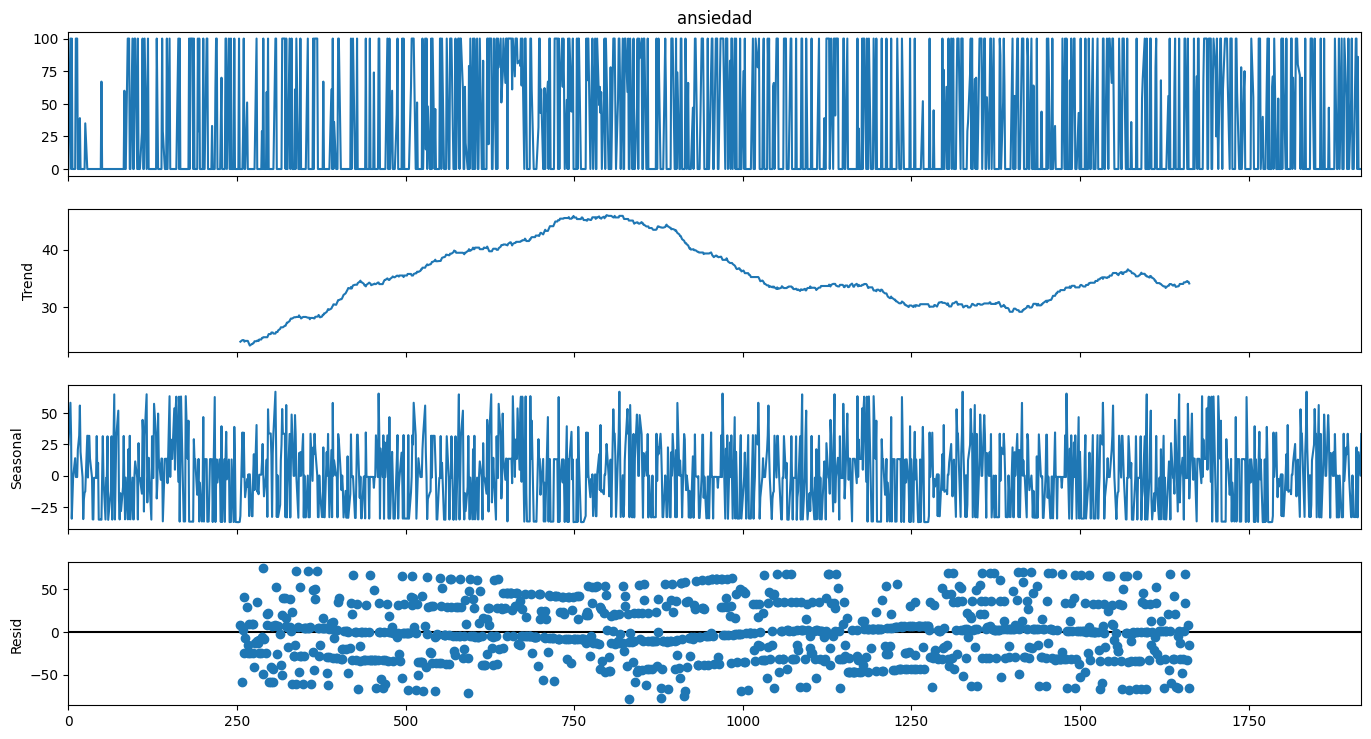

In [57]:
decomposition = seasonal_decompose(df.ansiedad, period = 365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

palabras = ['ansiedad', 'depresión', 'psicólogo', 'psicoterapia','desánimo']
# Crear un diccionario para almacenar las tendencias de cada palabra
tendencias = {}

for palabra in palabras:
    # Obtener la serie de tiempo para la palabra actual
    serie_tiempo = df[[palabra]].copy()
    
    # Aplicar la descomposición estacional
    decompose_result = seasonal_decompose(serie_tiempo, period=365)
    
    # Obtener la tendencia y almacenarla en el diccionario
    tendencia = decompose_result.trend
    tendencias[palabra] = tendencia

# Agregar las tendencias al DataFrame original
for palabra, tendencia in tendencias.items():
    df[palabra + '_tendencia'] = tendencia




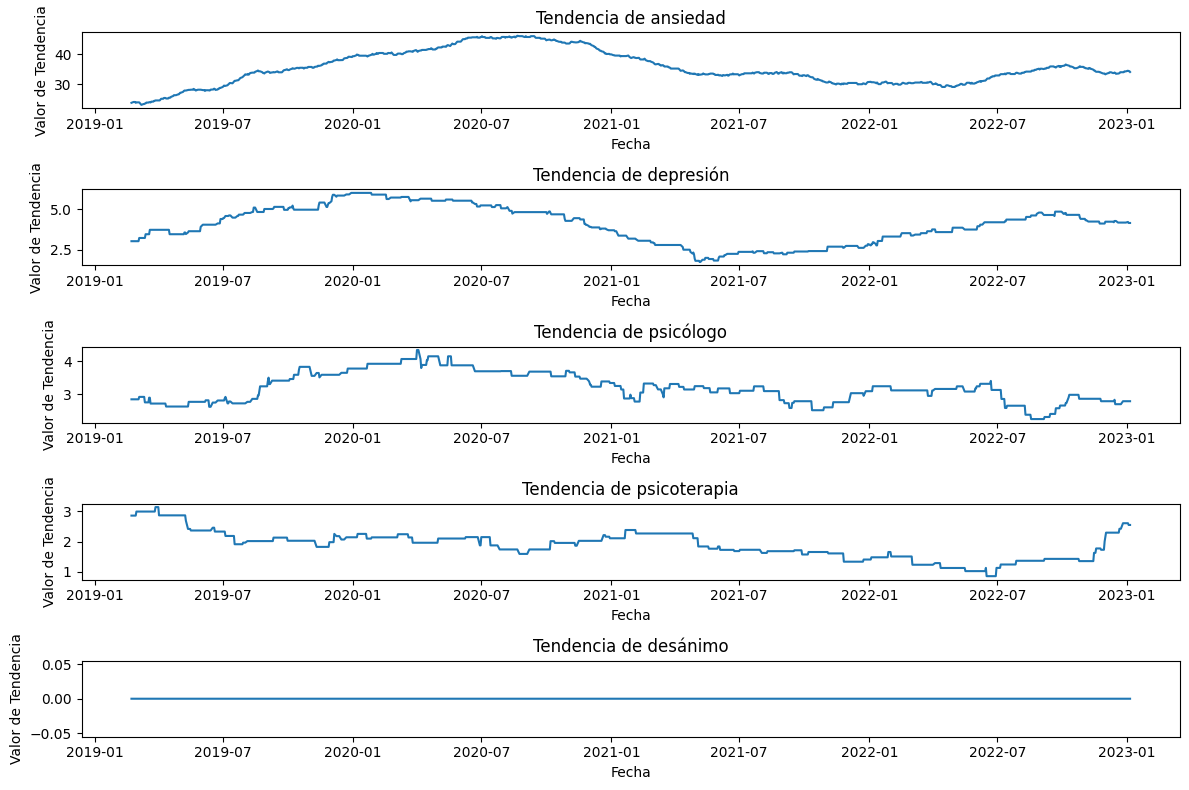

In [58]:
palabras = ['ansiedad', 'depresión', 'psicólogo', 'psicoterapia','desánimo']

# Crear subplots para cada palabra
fig, axs = plt.subplots(len(palabras), figsize=(12, 8))

for i, palabra in enumerate(palabras):
    # Seleccionar la columna de tendencia correspondiente
    columna_tendencia = df[palabra + '_tendencia']
    
    # Graficar la tendencia
    axs[i].plot(df['Fecha'], columna_tendencia)
    axs[i].set_title(f'Tendencia de {palabra}')
    axs[i].set_xlabel('Fecha')
    axs[i].set_ylabel('Valor de Tendencia')

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()







In [61]:
import pandas as pd
from prince import FAMD

# Supongamos que tienes un DataFrame df con las columnas de tendencia
# Las columnas de tendencia se llaman 'ansiedad_tendencia', 'depresión_tendencia', 'psicólogo_tendencia', 'psicoterapia_tendencia'

# Selecciona las columnas de tendencia que deseas incluir en el análisis
columnas_tendencia = df[['ansiedad_tendencia', 'depresión_tendencia', 'psicólogo_tendencia', 'psicoterapia_tendencia','desánimo_tendencia']]

# Crea un objeto FAMD
famd = (
    n_components=1,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

# Ajusta el modelo FAMD a tus datos
famd = famd.fit(columnas_tendencia)

# Muestra un resumen de los autovalores (eigenvalues)
print(famd.eigenvalues_)

# Dibuja los componentes principales
famd.plot_row_coordinates(
    columnas_tendencia,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=None,
    ellipse_outline=False,
)

# Muestra las contribuciones de las filas
contribuciones_filas = famd.row_contributions_
print(contribuciones_filas)

# Muestra las contribuciones de las columnas
contribuciones_columnas = famd.column_contributions_
print(contribuciones_columnas)


ValueError: All variables are quantitative: PCA should be used